# Analysis of chemo diversity on pharmacological and biological activities

Datasets are obtained by querying scopus

In [4]:
from pathlib import Path
from loader import load_chemo_activities, sort_by_class

FILENAME = Path("results/activities_2021-11-10_12-34-35.csv")
dataset = load_chemo_activities(FILENAME)

INFO:scopus_api:load_chemo_activities('results/activities_2021-11-10_12-34-35.csv') loaded


Pharmacological and biological activities, with their classes of activity (generalization)

In [7]:
dataset.activities

{'antioxidant': 'abiotic',
 'drought': 'abiotic',
 'metal': 'abiotic',
 'salt': 'abiotic',
 'uv': 'abiotic',
 'antifeedant': 'allelopathy',
 'arbuscula': 'allelopathy',
 'attractant': 'allelopathy',
 'germination': 'allelopathy',
 'herbicidal': 'allelopathy',
 'hppd': 'allelopathy',
 'hyphal': 'allelopathy',
 'phytotoxicity': 'allelopathy',
 'quorum sensing': 'allelopathy',
 'repulsive': 'allelopathy',
 'toxicant': 'allelopathy',
 'anti-inflammatory': 'pharmaco',
 'antibacterial': 'pharmaco',
 'anticancer': 'pharmaco',
 'antidiabetic': 'pharmaco',
 'antifungal': 'pharmaco',
 'antimicrobial': 'pharmaco',
 'antiparasitic': 'pharmaco',
 'antiviral': 'pharmaco',
 'arthritis': 'pharmaco',
 'burns': 'pharmaco',
 'cardiovascular': 'pharmaco',
 'cytotoxicity': 'pharmaco',
 'obesity': 'pharmaco',
 'rheumatism': 'pharmaco',
 'sedative': 'pharmaco',
 'wound': 'pharmaco',
 'toxicity': 'toxicity'}

Chemical compounds, with their classes of activity (generalization)

In [8]:
dataset.compounds

{'acridine': 'alkaloid',
 'benzylamine': 'alkaloid',
 'colchicine': 'alkaloid',
 'cyclopeptide': 'alkaloid',
 'imidazole': 'alkaloid',
 'indole': 'alkaloid',
 'indolizidine': 'alkaloid',
 'isoquinoline': 'alkaloid',
 'isoxazole': 'alkaloid',
 'muscarine': 'alkaloid',
 'oxazole': 'alkaloid',
 'phenylethylamine': 'alkaloid',
 'piperidine': 'alkaloid',
 'purine': 'alkaloid',
 'putrescine': 'alkaloid',
 'pyridine': 'alkaloid',
 'pyrrolidine': 'alkaloid',
 'pyrrolizidine': 'alkaloid',
 'quinazoline': 'alkaloid',
 'quinoline': 'alkaloid',
 'quinolizidine': 'alkaloid',
 'spermidine': 'alkaloid',
 'spermine': 'alkaloid',
 'thiazole': 'alkaloid',
 'tropane': 'alkaloid',
 'acetophenone': 'phenolic compound',
 'anthraquinone': 'phenolic compound',
 'biflavonoids': 'phenolic compound',
 'flavonoids': 'phenolic compound',
 'isoflavanoids': 'phenolic compound',
 'lignans': 'phenolic compound',
 'naphthoquinone': 'phenolic compound',
 'phenol': 'phenolic compound',
 'phenolic acid': 'phenolic compoun

## Analytics

In [9]:
# see https://github.com/MaxHalford/prince
import prince
import pandas as pd

pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))

In [13]:
# converts to pandas
df = pd.DataFrame(dataset.data).T
df.columns.rename('Activity', inplace=True)
df.index.rename('Compound', inplace=True)
df

Activity,antioxidant,drought,metal,salt,uv,antifeedant,arbuscula,attractant,germination,herbicidal,...,antiviral,arthritis,burns,cardiovascular,cytotoxicity,obesity,rheumatism,sedative,wound,toxicity
Compound,,,,,,,,,,,,,,,,,,,,,
acridine,262,2,250,163,78,1,0,0,11,1,...,117,26,16,45,1273,3,0,8,76,396
benzylamine,70,0,163,79,23,0,0,0,4,6,...,23,12,1,87,121,34,0,6,18,101
colchicine,185,4,82,185,19,0,0,0,44,0,...,102,1594,31,592,1243,168,19,34,219,860
cyclopeptide,57,1,167,34,16,0,0,0,17,1,...,92,674,1,77,509,44,6,4,49,168
imidazole,1069,7,2454,1183,297,3,0,1,52,8,...,1187,382,120,1253,2776,290,1,480,452,1748
indole,1299,53,1456,705,278,4,0,13,173,6,...,842,307,19,783,3626,338,12,78,338,1347
indolizidine,1,0,2,8,0,0,0,0,0,0,...,14,1,0,0,27,0,0,0,1,4
isoquinoline,135,2,146,141,20,2,0,0,6,3,...,319,58,5,103,621,32,0,18,26,181
isoxazole,123,2,77,135,20,0,0,0,4,13,...,228,508,2,77,359,56,2,27,49,271


In [17]:
ca = prince.CA(n_components=2, n_iter=3, copy=True, check_input=True, engine="auto", random_state=42)
ca = ca.fit(df)

# ca.row_coordinates(df)
# ca.column_coordinates(df)

ca.explained_inertia_

[0.3572050603478939, 0.17664755027476908]

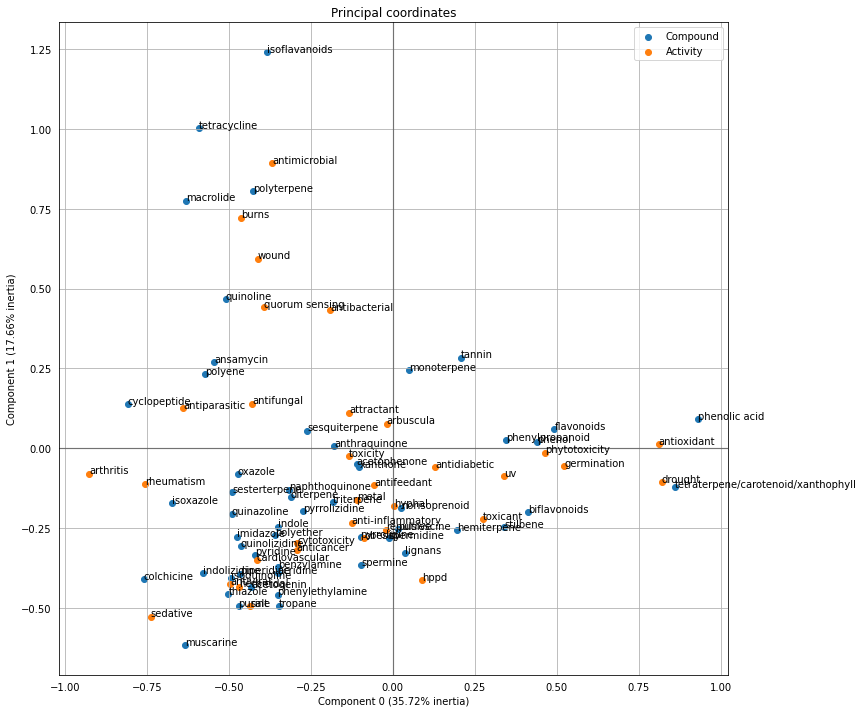

In [20]:
ax = ca.plot_coordinates(
     X=df,
     ax=None,
     figsize=(12, 12),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True
 )
